# **Music Theme Recognition**

Chuang Caleb
20204134

## **Package Imports**

In [247]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import VarianceThreshold

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids

from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, f1_score


## **Choosing Parameters**

In [248]:
target_label = 'risk'

k_value = 3

# feature_start = 'Range'
# feature_end = 'Metrical_Diversity'
feature_start = 'Most_Common_Melodic_Interval'
feature_end = 'Melodic_Pitch_Variety'

threshold_val = 0

rand_state = 12

## **Importing Dataset**

#### Features

In [249]:
# Access song_theme_feature_database
song_theme_feature_database_path = '../data/features/song_theme_feature_database.csv'
raw_feature_df = pd.read_csv(song_theme_feature_database_path)


#### Labels

In [250]:
# Access song_theme_labels_database
song_theme_label_database_path = '../data/song_theme_label_database.xlsx'
raw_label_df = pd.read_excel(song_theme_label_database_path)

## **Prepare datasets**

### Manual Selection

Select the features for this iteration

In [251]:
man_feature_df = raw_feature_df.loc[:,feature_start:feature_end]


Select the labels for this iteration

In [252]:
# Filter for only recognized samples in labels_df
main_label_df = raw_label_df[raw_label_df.recognizable == 1]

# Filter out unused labels and metadata
main_label_df.drop(
    columns=main_label_df.columns[19:], axis=1, inplace=True)  # unused labels
main_label_df.drop(
    columns=main_label_df.columns[0:4], axis=1, inplace=True)  # metadata

# label_df = main_label_df
# label_df = main_label_df[target_label]
label_df = main_label_df[[target_label]]
# label_df

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Feature Selection

Filter out features with zero variance

In [253]:
constant_filter = VarianceThreshold(threshold=threshold_val)
constant_filter.fit(man_feature_df)
constant_columns = [column for column in man_feature_df.columns
                    if column not in
                    man_feature_df.columns[constant_filter.get_support()]]
var_feature_df = constant_filter.transform(man_feature_df)
# x_test = constant_filter.transform(label_df)
# for column in constant_columns:
#     print("Removed ", column)
print(f"Started with {man_feature_df.shape[1]} features.")
print(
    f"Removed {len(constant_columns)} features that have a variance of {threshold_val}.")
print(f"There are {(var_feature_df.shape[1])} features left.")

feature_names = [x for x in man_feature_df.columns if not x in constant_columns]

Started with 24 features.
Removed 0 features that have a variance of 0.
There are 24 features left.


Filter out features with low importance

## **Transforming Data**

In [254]:
# from numpy import ravel

# feature_np = feature_df.to_numpy()
# label_np = label_df.to_numpy()
# # feature_np = feature_df
# # label_np = label_df

# feature_np = feature_df.to_numpy()
feature_np = var_feature_df
label_np = label_df.to_numpy().astype(int)

ids_df = raw_feature_df['sample']


### Splitting dataset

In [255]:
(x_train, x_test, y_train, y_test, ids_train, ids_test) = train_test_split(
    feature_np, label_np, ids_df, test_size=0.2, random_state=rand_state)

In [256]:
var_feature_df.shape

(130, 24)

### Sampling Data 
For balanced dataset

In [257]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0,shrinkage= 0.4)
# X_resampled, y_resampled = ros.fit_resample(x_train, y_train)

# from collections import Counter
# print(sorted(Counter(y_resampled).items()))


In [258]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(x_train, y_train)

# from collections import Counter
# print(sorted(Counter(y_resampled).items()))

In [259]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=888)
# x_train, y_train = smote.fit_resample(x_train, y_train)

# y_train.value_counts()


## **Working Model**

In [260]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# from sklearn.pipeline import make_pipeline
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_validate


# model_with_selection = make_pipeline(
#     SelectKBest(score_func=f_classif, k=2),
#     RandomForestClassifier(n_jobs=2),
# )

# label_np = ravel(label_np)

# cv_results_with_selection = cross_validate(
#     model_with_selection, feature_np, label_np, return_estimator=True)
# cv_results_with_selection = pd.DataFrame(cv_results_with_selection)

# cv_results_with_selection

In [261]:
from sklearn.tree import DecisionTreeClassifier

parameters = {'k': range(3,5), 's': [0.5, 0.7, 1.0]}
score = 'f1_macro'
# from imblearn.ensemble import BalancedRandomForestClassifier

# classifier = GridSearchCV(MLkNN(), parameters, scoring=score)
# classifier = MLkNN()
classifier = DecisionTreeClassifier(max_leaf_nodes=10,random_state=rand_state)
# classifier = BalancedRandomForestClassifier(n_estimators=500, random_state=rand_state)
classifier.fit(x_train, y_train)

# print(classifier.best_params_, classifier.best_score_)
# classifier.fit(X_resampled, y_resampled)

DecisionTreeClassifier(max_leaf_nodes=10, random_state=12)

[Text(0.5357142857142857, 0.9166666666666666, 'Melodic_Perfect_Fourths <= 0.062\ngini = 0.286\nsamples = 104\nvalue = [86, 18]\nclass = null'),
 Text(0.2857142857142857, 0.75, 'Relative_Prevalence_of_Most_Common_Melodic_Intervals <= 0.563\ngini = 0.497\nsamples = 24\nvalue = [11, 13]\nclass = risk'),
 Text(0.14285714285714285, 0.5833333333333334, 'Melodic_Large_Intervals <= 0.169\ngini = 0.198\nsamples = 9\nvalue = [1, 8]\nclass = risk'),
 Text(0.07142857142857142, 0.4166666666666667, 'gini = 0.0\nsamples = 8\nvalue = [0, 8]\nclass = risk'),
 Text(0.21428571428571427, 0.4166666666666667, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = null'),
 Text(0.42857142857142855, 0.5833333333333334, 'Relative_Prevalence_of_Most_Common_Melodic_Intervals <= 0.765\ngini = 0.444\nsamples = 15\nvalue = [10, 5]\nclass = null'),
 Text(0.35714285714285715, 0.4166666666666667, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]\nclass = null'),
 Text(0.5, 0.4166666666666667, 'Direction_of_Melodic_Motion <= 0.437\n

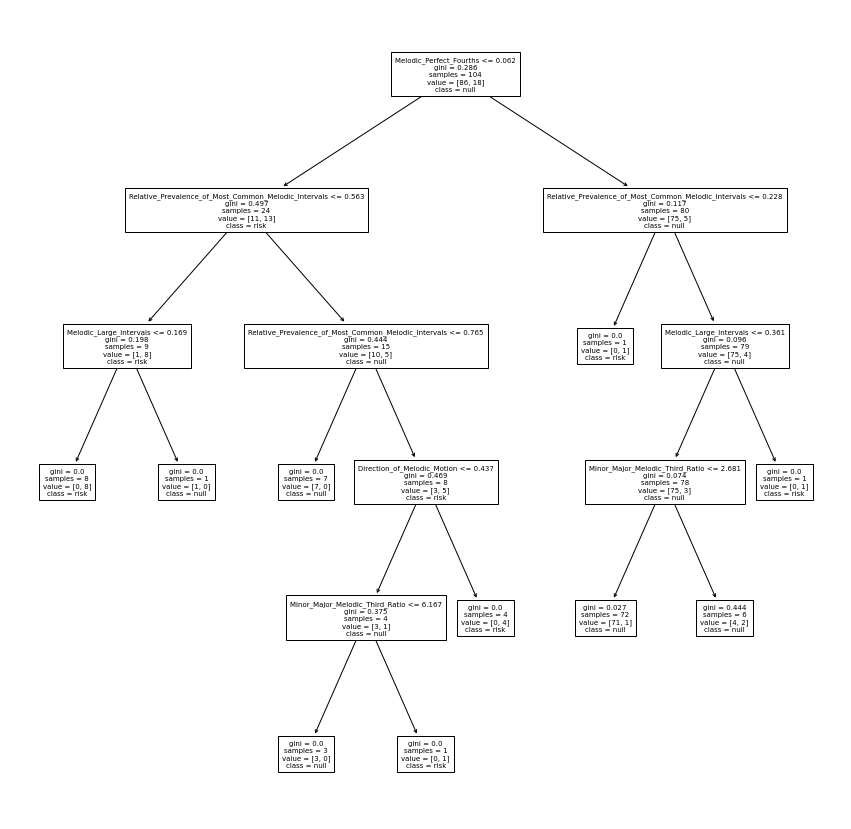

In [262]:
from sklearn.tree import export_text
from sklearn import tree
import matplotlib.pyplot as plt

# print(export_text(classifier, feature_names=final_columns))

plt.figure(figsize=(15,15))  
tree.plot_tree(classifier,feature_names=feature_names, class_names=['null',target_label],fontsize=7)

## **Evaluation**

### Prediction

In [263]:
predictions = classifier.predict(x_test)

### Metrics

In [264]:
# scores = cross_val_score(classifier, x_test, y_test, cv=3, scoring='accuracy')

print('Accuracy: ' + str(accuracy_score(y_test, predictions)))
print('Haming Loss: ' +  str(hamming_loss(y_test, predictions)))
print('F1-score: ' +  str(f1_score(y_test, predictions)))


Accuracy: 0.8461538461538461
Haming Loss: 0.15384615384615385
F1-score: 0.6


Display results

In [265]:
predictions_df = pd.DataFrame(predictions, columns = label_df.columns)
y_test_df = pd.DataFrame(predictions, columns = label_df.columns)

results = pd.DataFrame(
    # {'sample': ids_test, 'y_true': flat_y_true, 'y_pred': flat_predictions})
    # {'sample': ids_test, 'y_true': y_test, 'y_pred': predictions})
    {'sample': ids_test.reset_index(drop=True), 'y_true': y_test_df[target_label], 'y_pred':predictions_df[target_label]})

results = results.sort_index()

results

,sample,y_true,y_pred
0,Disney Themes_You've Got A Friend_midiworld.mid,0,0
1,disney_bitmidi.mid,1,1
2,ELO - Mr Blue Sky_bitmidi.mid,0,0
3,coldplay-a_sky_full_of_stars_bitmidi.mid,0,0
4,Aladdin(PrinceAli)_bitmidi.mid,0,0
5,A-Thousand-Hours_bitmidi.mid,0,0
6,TV Themes_Pokemon_midiworld.mid,0,0
7,imperial_bitmidi.mid,1,1
8,ABBA.The winner takes it all K_bitmidi.mid,0,0
9,Movie Themes_Star Trek First Contact_midiworld...,0,0
